In [5]:
import numpy as np
import pandas as pd
import pydicom
%matplotlib inline
import matplotlib.pyplot as plt
import keras 
import cv2
import json

In [6]:
filename = 'test1.dcm'
ds = pydicom.dcmread(filename) 
#ds.dir()
print('ds type is ', type(ds))
#ds.group_dataset

temp = ds.pixel_array
print('temp type is ', type(temp), ' and  shape is ', temp.shape)

ds type is  <class 'pydicom.dataset.FileDataset'>
temp type is  <class 'numpy.ndarray'>  and  shape is  (1024, 1024)


In [7]:
# This function reads in a .dcm file, checks the important fields for our device, and returns a numpy array
# of just the imaging data
def check_dicom(filename): 
    '''
    Reference
    ---------
    Differentn views and meaning of PA and AP in chest x-rays
    https://en.wikipedia.org/wiki/Chest_radiograph
    
    DICOM reprsentation abbrievations
    https://wiki.cancerimagingarchive.net/display/Public/DICOM+Modality+Abbreviations
    '''
    img = None
    print('Loading file {} ...'.format(filename))
    ds = pydicom.dcmread(filename)       
    bodypart_check      = ds.BodyPartExamined == 'CHEST' or ds.BodyPartExamined == 'RIBCAGE'
    bodyposition_check  = ds.PatientPosition =='PA' or ds.PatientPosition =='AP'
    imaging_type_check  = ds.Modality == 'DX'
    #photo_format_check = ds.PhotometricInterpretation == 'MONOCHROME2'
    
    if (bodypart_check and bodyposition_check and imaging_type_check):
        img = ds.pixel_array  
        print(filename, ' read succesfully')
    else:
        print(ds.BodyPartExamined, ds.PatientPosition, ds.Modality)
        
    #print('--------------------------')
    return img
    
    
# This function takes the numpy array output by check_dicom and 
# runs the appropriate pre-processing needed for our model input
def preprocess_image(img,img_mean,img_std,img_size): 
    '''
    Reference
    ---------
    Preprocessing for common models
    https://towardsdatascience.com/image-pre-processing-c1aec0be3edf
    https://github.com/hadrienj/Preprocessing-for-deep-learning
    https://machinelearningmastery.com/best-practices-for-preparing-and-augmenting-image-data-for-convolutional-neural-networks/
    https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
    '''
    resized_img = cv2.resize(img, (img_size[1], img_size[2]), interpolation= cv2.INTER_LINEAR)
    color_img   = cv2.cvtColor(resized_img,cv2.COLOR_GRAY2RGB)
    norm_img    = (color_img - img_mean) / img_std
    proc_img    = np.expand_dims(norm_img , axis=0)
    #print(proc_img.shape)
    return proc_img

# This function loads in our trained model w/ weights and compiles it 
def load_model(model_path, weight_path):
    '''
    Reference
    ---------
    https://www.tensorflow.org/guide/keras/save_and_serialize
    https://keras.io/api/models/model_saving_apis/
    '''
    with open(model_path) as file:
        model_data = file.read()
    #print(type(model_data))
    model =keras.models.model_from_json(model_data)
    model.load_weights(weight_path)
    return model

# This function uses our device's threshold parameters to predict whether or not
# the image shows the presence of pneumonia using our trained model
def predict_image(model, img, thresh): 
    prediction = model.predict(img) > thresh
    return prediction 

Loading file test1.dcm ...
test1.dcm  read succesfully
Prediction for below image is : True


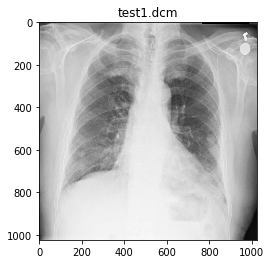

--------------------------
Loading file test2.dcm ...
test2.dcm  read succesfully
Prediction for below image is : True


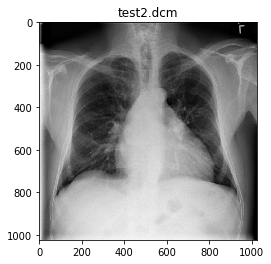

--------------------------
Loading file test3.dcm ...
test3.dcm  read succesfully
Prediction for below image is : True


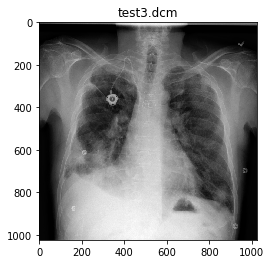

--------------------------
Loading file test4.dcm ...
test4.dcm  read succesfully
Prediction for below image is : True


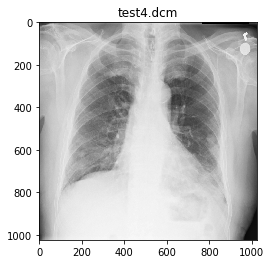

--------------------------
Loading file test5.dcm ...
CHEST PA CT
--------------------------
Loading file test6.dcm ...
CHEST XX DX
--------------------------


In [8]:
test_dicoms = ['test1.dcm','test2.dcm','test3.dcm','test4.dcm','test5.dcm','test6.dcm']

model_path = 'my_model.json'                  #path to saved model
weight_path = 'xray_class_my_model.best.hdf5' #path to saved best weights

IMG_SIZE =(1,224,224,3)                     # This might be different if you did not use vgg16
img_mean = np.random.rand(224, 224, 3)         # loads the mean image value they used during training preprocessing
img_std  = np.random.rand(224, 224, 3)         # loads the std dev image value they used during training preprocessing

my_model = load_model(model_path, weight_path) # loads model
thresh   = 0.35                                # loads the threshold they chose for model classification 

# use the .dcm files to test your prediction
for i in test_dicoms:
    
    img = np.array([])
    img = check_dicom(i)
    if img is None:
        print('--------------------------')
        continue
        
    img_proc = preprocess_image(img,img_mean,img_std,IMG_SIZE)
    pred = predict_image(my_model,img_proc,thresh)
    print('Prediction for below image is : {}'.format(pred[0][0]))
    #plot image result
    plt.imshow(img, cmap='gray')
    plt.title(i)
    plt.show()
    print('--------------------------')